In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv
/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
import shap


In [3]:
# Initialize shap
shap.initjs()

In [4]:
USE_DATA_LEAK = 'Y'   # Set to 'Y' to exploit data leak
num_folds = 5         # Number of folds
n_est = 3500           # Number of estimators
RAND_VAL = 42

df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df_test_ov = df_test.copy()

In [5]:
scale_cols = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']

for c in scale_cols:
    min_value = df_train[c].min()
    max_value = df_train[c].max()
    df_train[f"{c}_scaled"] = (df_train[c] - min_value) / (max_value - min_value)
    df_test[f"{c}_scaled"] = (df_test[c] - min_value) / (max_value - min_value)

def get_features(df):
    df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 60 else 0)
    df['IsActive_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Products_Per_Tenure'] = df['Tenure'] / df['NumOfProducts']
    df['AgeCat'] = (df["Age"] // 20).astype('int').astype('category')
    df['Sur_Geo_Gend_Sal'] = (df['Surname'] + df['Geography'] + df['Gender'] +
                              np.round(df.EstimatedSalary).astype('str'))
    return df

df_train = get_features(df_train)
df_test = get_features(df_test)

In [6]:
feat_cols = df_train.columns.drop(['id', 'Exited'])
feat_cols = feat_cols.drop(scale_cols)

X = df_train[feat_cols]
y = df_train['Exited']

cat_features = np.where(X.dtypes != np.float64)[0]

In [7]:
folds = StratifiedKFold(n_splits=num_folds, random_state=RAND_VAL, shuffle=True)


In [8]:
test_preds = np.empty((num_folds, len(df_test)))
auc_vals = []

In [9]:
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    val_pool = Pool(X_val, y_val, cat_features=cat_features)

    clf = CatBoostClassifier(
        eval_metric='AUC',
        learning_rate=0.022,
        iterations=n_est,
        task_type="GPU"  # Run on GPU in Kaggle environment
    )
    
    clf.fit(train_pool, eval_set=val_pool, verbose=300)

    y_pred_val = clf.predict_proba(X_val[feat_cols])[:, 1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold", n_fold, ":", auc_val)
    auc_vals.append(auc_val)

    y_pred_test = clf.predict_proba(df_test[feat_cols])[:, 1]
    test_preds[n_fold, :] = y_pred_test
    print("----------------")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8603216	best: 0.8603216 (0)	total: 151ms	remaining: 8m 47s
300:	test: 0.8940140	best: 0.8940140 (300)	total: 7.98s	remaining: 1m 24s
600:	test: 0.8956031	best: 0.8956031 (600)	total: 16s	remaining: 1m 17s
900:	test: 0.8961177	best: 0.8961177 (900)	total: 23.7s	remaining: 1m 8s
1200:	test: 0.8964753	best: 0.8964753 (1200)	total: 31.4s	remaining: 1m
1500:	test: 0.8965838	best: 0.8966011 (1420)	total: 39.1s	remaining: 52.1s
1800:	test: 0.8966335	best: 0.8966368 (1635)	total: 47.1s	remaining: 44.4s
2100:	test: 0.8966628	best: 0.8966628 (2100)	total: 55s	remaining: 36.6s
2400:	test: 0.8966763	best: 0.8967034 (2245)	total: 1m 2s	remaining: 28.8s
2700:	test: 0.8966876	best: 0.8967034 (2245)	total: 1m 11s	remaining: 21s
3000:	test: 0.8966563	best: 0.8967034 (2245)	total: 1m 19s	remaining: 13.2s
3300:	test: 0.8966270	best: 0.8967034 (2245)	total: 1m 27s	remaining: 5.28s
3499:	test: 0.8965992	best: 0.8967034 (2245)	total: 1m 32s	remaining: 0us
bestTest = 0.8967034221
bestIteration = 2

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8743140	best: 0.8743140 (0)	total: 40ms	remaining: 2m 20s
300:	test: 0.8943851	best: 0.8943851 (300)	total: 7.71s	remaining: 1m 21s
600:	test: 0.8960837	best: 0.8960837 (600)	total: 15.7s	remaining: 1m 15s
900:	test: 0.8965740	best: 0.8965759 (895)	total: 23.6s	remaining: 1m 8s
1200:	test: 0.8969110	best: 0.8969110 (1200)	total: 31.5s	remaining: 1m
1500:	test: 0.8971130	best: 0.8971130 (1500)	total: 39.4s	remaining: 52.4s
1800:	test: 0.8972951	best: 0.8972989 (1790)	total: 47.7s	remaining: 45s
2100:	test: 0.8974125	best: 0.8974125 (2100)	total: 55.7s	remaining: 37.1s
2400:	test: 0.8975044	best: 0.8975067 (2320)	total: 1m 3s	remaining: 29.2s
2700:	test: 0.8975170	best: 0.8975280 (2675)	total: 1m 11s	remaining: 21.2s
3000:	test: 0.8975422	best: 0.8975422 (3000)	total: 1m 19s	remaining: 13.3s
3300:	test: 0.8975052	best: 0.8975540 (3105)	total: 1m 27s	remaining: 5.3s
3499:	test: 0.8975083	best: 0.8975540 (3105)	total: 1m 33s	remaining: 0us
bestTest = 0.89755404
bestIteration = 3

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8746591	best: 0.8746591 (0)	total: 40.3ms	remaining: 2m 20s
300:	test: 0.8948451	best: 0.8948451 (300)	total: 8.15s	remaining: 1m 26s
600:	test: 0.8966567	best: 0.8966567 (600)	total: 15.8s	remaining: 1m 16s
900:	test: 0.8974131	best: 0.8974131 (900)	total: 23.6s	remaining: 1m 8s
1200:	test: 0.8977841	best: 0.8977874 (1190)	total: 31.4s	remaining: 1m
1500:	test: 0.8980657	best: 0.8980694 (1495)	total: 39.6s	remaining: 52.7s
1800:	test: 0.8981867	best: 0.8981923 (1770)	total: 47.5s	remaining: 44.8s
2100:	test: 0.8983490	best: 0.8983490 (2100)	total: 55.3s	remaining: 36.8s
2400:	test: 0.8984208	best: 0.8984210 (2395)	total: 1m 3s	remaining: 28.9s
2700:	test: 0.8984610	best: 0.8984637 (2670)	total: 1m 11s	remaining: 21.1s
3000:	test: 0.8984763	best: 0.8984877 (2880)	total: 1m 19s	remaining: 13.2s
3300:	test: 0.8984975	best: 0.8984975 (3300)	total: 1m 27s	remaining: 5.28s
3499:	test: 0.8985022	best: 0.8985053 (3495)	total: 1m 32s	remaining: 0us
bestTest = 0.8985053301
bestIterat

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8657124	best: 0.8657124 (0)	total: 43.5ms	remaining: 2m 32s
300:	test: 0.8953815	best: 0.8953815 (300)	total: 7.73s	remaining: 1m 22s
600:	test: 0.8970851	best: 0.8970851 (600)	total: 15.3s	remaining: 1m 13s
900:	test: 0.8977482	best: 0.8977482 (900)	total: 23.1s	remaining: 1m 6s
1200:	test: 0.8980628	best: 0.8980628 (1200)	total: 31.3s	remaining: 59.8s
1500:	test: 0.8983040	best: 0.8983040 (1500)	total: 39s	remaining: 52s
1800:	test: 0.8984467	best: 0.8984519 (1690)	total: 46.8s	remaining: 44.2s
2100:	test: 0.8985785	best: 0.8985888 (2075)	total: 54.8s	remaining: 36.5s
2400:	test: 0.8986113	best: 0.8986238 (2360)	total: 1m 3s	remaining: 28.9s
2700:	test: 0.8986743	best: 0.8986835 (2615)	total: 1m 11s	remaining: 21s
3000:	test: 0.8986785	best: 0.8986883 (2885)	total: 1m 19s	remaining: 13.2s
3300:	test: 0.8986920	best: 0.8987026 (3240)	total: 1m 27s	remaining: 5.26s
3499:	test: 0.8986501	best: 0.8987026 (3240)	total: 1m 32s	remaining: 0us
bestTest = 0.8987025619
bestIteration

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8675809	best: 0.8675809 (0)	total: 41.3ms	remaining: 2m 24s
300:	test: 0.8929617	best: 0.8929617 (300)	total: 7.96s	remaining: 1m 24s
600:	test: 0.8944656	best: 0.8944656 (600)	total: 15.8s	remaining: 1m 16s
900:	test: 0.8950161	best: 0.8950198 (895)	total: 23.4s	remaining: 1m 7s
1200:	test: 0.8952859	best: 0.8952873 (1195)	total: 31.5s	remaining: 1m
1500:	test: 0.8954445	best: 0.8954455 (1495)	total: 39.3s	remaining: 52.3s
1800:	test: 0.8955321	best: 0.8955321 (1800)	total: 47.2s	remaining: 44.6s
2100:	test: 0.8955413	best: 0.8955520 (1905)	total: 55.1s	remaining: 36.7s
2400:	test: 0.8955676	best: 0.8955778 (2220)	total: 1m 3s	remaining: 29s
2700:	test: 0.8956003	best: 0.8956395 (2615)	total: 1m 11s	remaining: 21.1s
3000:	test: 0.8955873	best: 0.8956395 (2615)	total: 1m 19s	remaining: 13.2s
3300:	test: 0.8955818	best: 0.8956395 (2615)	total: 1m 27s	remaining: 5.29s
3499:	test: 0.8955832	best: 0.8956395 (2615)	total: 1m 33s	remaining: 0us
bestTest = 0.8956394792
bestIteratio

In [10]:
print("Mean AUC:", np.mean(auc_vals))


Mean AUC: 0.8974210040466067


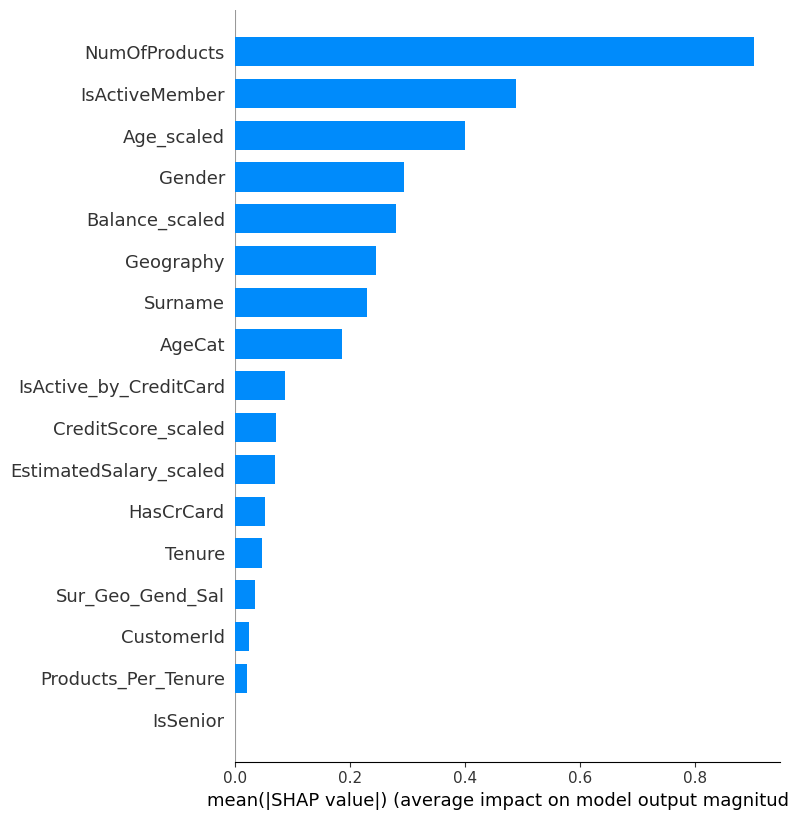

In [11]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(train_pool)

shap.summary_plot(shap_values, X_train, plot_type="bar")


In [12]:
df_sub = pd.DataFrame({'id': df_test_ov['id'], 'Exited': test_preds.mean(axis=0)})

df_sub.to_csv("submission.csv", index=False)